# Experiment 4

Preprocessing Techniques -> Flip + Rotation + Zoom + Contrast adjustment

## Data Preprocessing and Visualization

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

2025-05-09 16:36:35.634437: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 16:36:35.779368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746804995.899946  253410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746804995.946368  253410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746804996.123757  253410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Loading the dataset using tensorflow's image_dataset_from_directory function
image_size = (256, 256)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "dataset/train",
    label_mode="categorical",
    image_size=image_size,
    batch_size=32,
    shuffle=True,
    seed=123,
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    "dataset/test",
    label_mode="categorical",
    image_size=image_size,
    batch_size=32,
    shuffle=False,
    seed=123,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    "dataset/val",
    label_mode="categorical",
    image_size=image_size,
    batch_size=32,
    shuffle=False,
    seed=123,
)


Found 1336 files belonging to 2 classes.


I0000 00:00:1746805000.564754  253410 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4396 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 238 files belonging to 2 classes.
Found 234 files belonging to 2 classes.


In [3]:
# Let us define the augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

In [4]:
# We would sample a batch from the dataset to visualize the augmentation
sample_batch = next(iter(train_dataset.take(1)))
sample_images, sample_labels = sample_batch

# Apply augmentations to the sample images
augmented_images = data_augmentation(sample_images[:5])

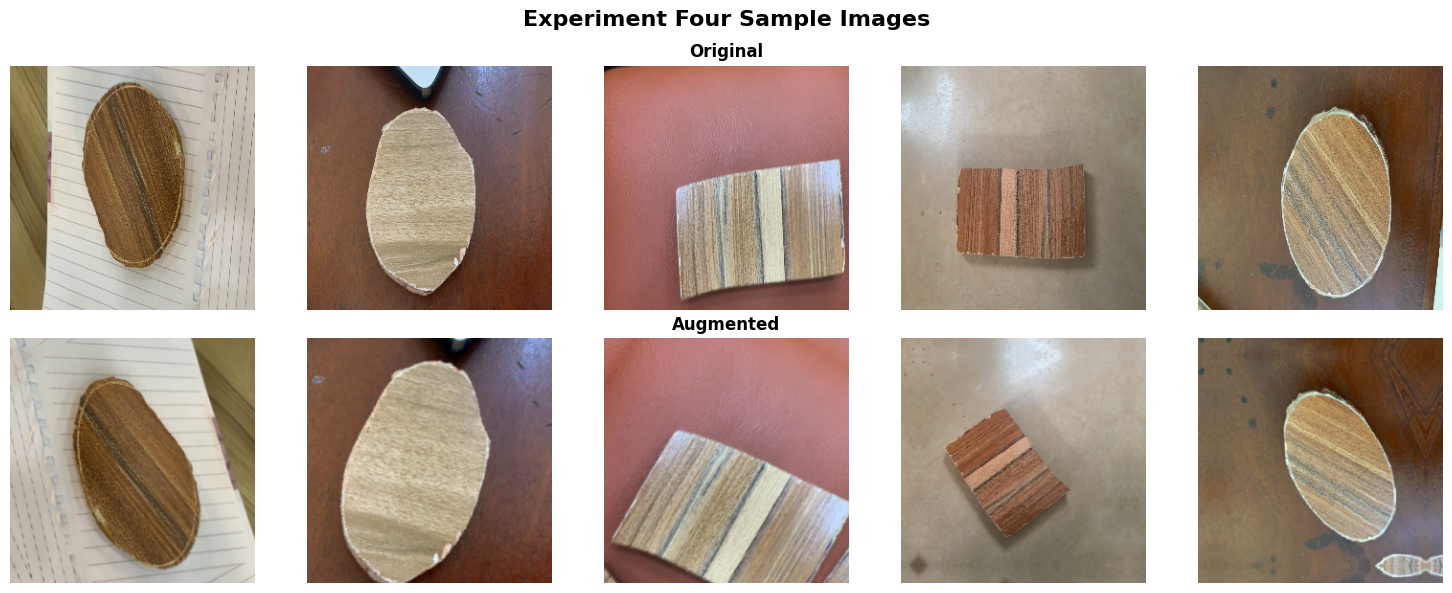

In [5]:
# We would visualize the augmented data samples
# Visualize
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(sample_images[i].numpy().astype("uint8"))
    axes[0, i].axis("off")
    if i == 2:
        axes[0, i].set_title("Original", fontsize=12, fontweight="bold")

    axes[1, i].imshow(augmented_images[i].numpy().astype("uint8"))
    axes[1, i].axis("off")
    if i == 2:
        axes[1, i].set_title("Augmented", fontsize=12, fontweight="bold")

plt.suptitle("Experiment Four Sample Images", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig("./plots/experiment_four_sample_images.png")
plt.show()

## Model Creation and Training

In [ ]:
# We would ResNet50 and perform transfer learning
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
    weights="imagenet",
    pooling="avg"
)

# Freeze the weights of the base model
base_model.trainable = False

# Final model with augmentation
model = tf.keras.Sequential([
    data_augmentation,  # Augmentation layer
    base_model,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax")
])

In [7]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (5, 256, 256, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (5, 2048)              │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (5, 32)                │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (5, 2)                 │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,653,346 (90.23 MB)

 Trainable params: 65,634 (256.38 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
# Compiling the model and adding callbacks
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
    tf.keras.callbacks.ModelCheckpoint("./models/experiment_four_resnet50.keras", monitor="val_accuracy", save_best_only=True),
]

epochs = 5

In [9]:
# ----- Initiating training ------ #
model_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/5


I0000 00:00:1746805011.646086  253523 cuda_dnn.cc:529] Loaded cuDNN version 90501


42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - accuracy: 0.9011 - loss: 0.2088 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 4.7769e-04
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.9992 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 3.1890e-04
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 6.7213e-04
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 1.0000 - loss: 8.8414e-04 - val_accuracy: 1.0000 - val_loss: 2.9151e-04


## Model Evaluation

In [10]:
from helpers import plot_training_curves, show_evaluation_report

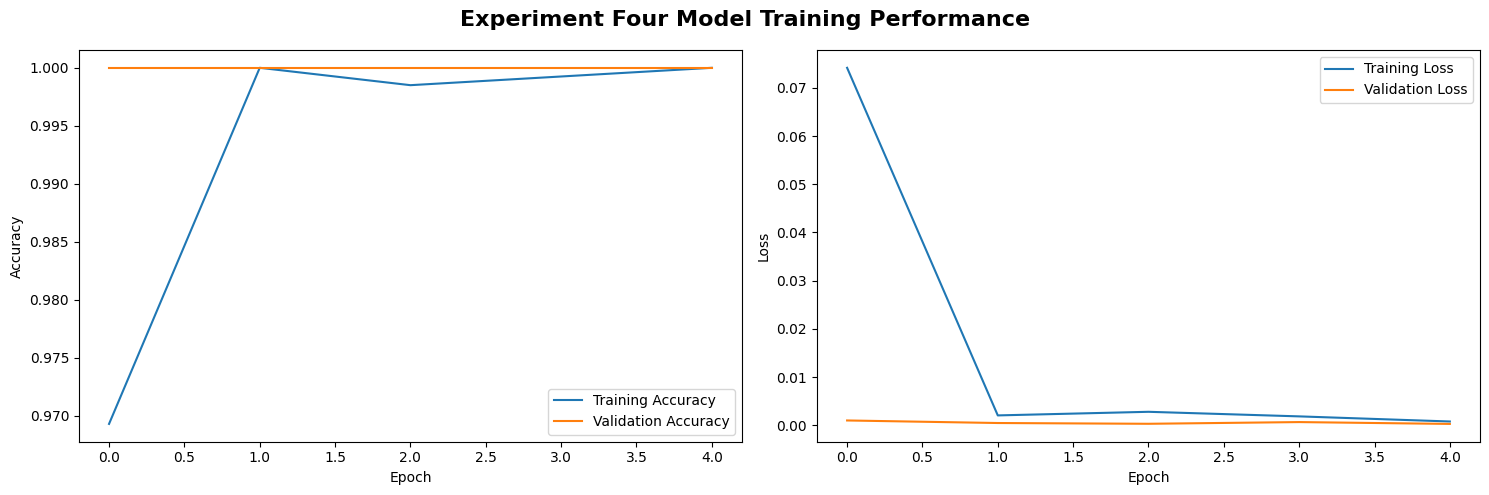

In [11]:
plot_training_curves(
    model_history.history,
    filename="experiment_four_training_curves.png",
    title="Experiment Four Model Training Performance"
)

In [12]:
# Load the best model
best_model = tf.keras.models.load_model("./models/experiment_four_resnet50.keras")

2025-05-09 16:37:47.096465: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 503ms/step


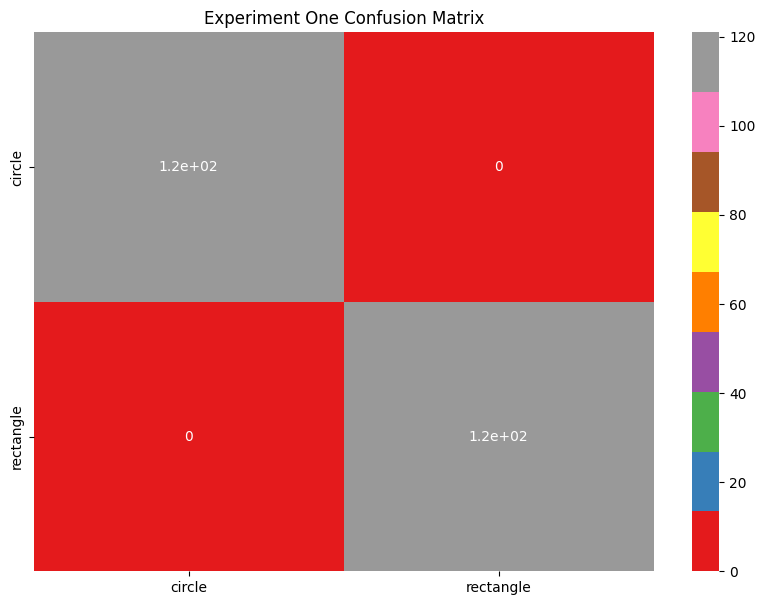



Classification Report:

              precision    recall  f1-score   support

      circle       1.00      1.00      1.00       117
   rectangle       1.00      1.00      1.00       121

    accuracy                           1.00       238
   macro avg       1.00      1.00      1.00       238
weighted avg       1.00      1.00      1.00       238



Model Accuracy: 1.00


In [13]:
# ----- Evaluating the model ------ #
show_evaluation_report(
    best_model,
    [test_dataset],
    filename="experiment_one_confusion_matrix.png",
    matrix_title="Experiment One Confusion Matrix"
)